In [5]:
import pandas as pd
import glob
import numpy as np
import json
from skbio import OrdinationResults
from biom import load_table

#plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Define function

In [2]:
titles_ = {'metabolite_logratio':'Metabolites',
           'mag_logratio':'Bacterial Genomes (MetaG)',
           '18S_logratio':'Eukaryotes (18S)',
           'gene_module_logratio':'Functional Modules (MetaG)'}
palette = ["#228b22","#76ee00","#7a378b"]
lr_cols = titles_.keys()

def log_ratio_plot(meta_logratios, x='add_0c_group', hue='facility',
                   hue_order = ['ARF', 'STAFS', 'FIRS'], palette=palette,
                   order = ['initial', 'early', 'active', 'advanced'],
                   figsize=(5*5, 5), save=False, save_path=None):

    fig, axn = plt.subplots(1, 4, figsize=figsize)
    for ax, lr_ in zip(axn, lr_cols):
        sns.pointplot(x=x, y=lr_, 
                      hue=hue, hue_order=hue_order,
                      palette=palette, order=order, 
                      data=meta_logratios, ax=ax)
        #plotting details
        ax.set_xlabel('Decomposition Stage', color='black', fontsize=20)
        ax.set_ylabel('$log(\\frac{advanced\,\,associated}{initial\,\,associated})$',
                    color='black', weight='bold', fontsize=22)
        ax.set_title(titles_[lr_], color='black', weight='bold', fontsize=20)
        # fix backround
        ax.set_facecolor('white')
        ax.set_axisbelow(True)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['top'].set_visible(False)
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('grey')
        for tick in ax.get_yticklabels():
            tick.set_fontproperties('arial')
            tick.set_weight('bold')
            tick.set_color("black")
            tick.set_fontsize(12)
        for tick in ax.get_xticklabels():
            tick.set_fontproperties('arial')
            tick.set_weight('bold')
            tick.set_color("black")
            tick.set_fontsize(12)
        ax.legend_.remove()

    legend = ax.legend(loc=2, bbox_to_anchor=(1, 1), prop={'size':18}, title="",
                       fancybox=True, framealpha=.0, ncol=1, markerscale=1.5)
    legend.get_title().set_fontsize('16')
    # increase the line width in the legend 
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
    if save:
        plt.savefig(save_path,
                    dpi=600, 
                    bbox_inches='tight',
                    edgecolor='none')
    plt.show()

### Joint-RPCA Trajectories

In [3]:
ord_joint = OrdinationResults.read('../results/joint-rpca/Original/ord.txt')
ord_joint_feats = ord_joint.features.copy()
axis_use = 1 # use PC2

# import tables data 
metadata_subset = pd.read_csv('../data/split-matched-data/metadata.tsv', sep='\t', index_col=0)
tables = {}
for table_ in glob.glob('../data/split-matched-data/*.biom'):
    if '16S' in table_:
        continue
    if 'gene.biom' in table_:
        continue
    bt_tmp = load_table(table_)
    bt_tmp_df = pd.DataFrame(bt_tmp.matrix_data.toarray(), bt_tmp.ids('observation'), bt_tmp.ids())
    bt_tmp_df = bt_tmp_df[metadata_subset.index]
    id_set = set(ord_joint_feats.index) & set(bt_tmp.ids('observation'))
    ord_joint_feats_tmp = ord_joint_feats.loc[list(id_set), :]
    ord_joint_feats_tmp = ord_joint_feats_tmp.sort_values(by=axis_use, ascending=False)
    tables[table_.split('/')[-1].split('.')[0]] = [bt_tmp, bt_tmp_df, ord_joint_feats_tmp]
tables.keys()

dict_keys(['metabolite', 'mag', '18S', 'gene_module', 'metabolomics'])

In [4]:
#reformat metabolite table - keep only those with most specific class ids
metab_ids = pd.read_excel('../data/metabolite_formulas.xlsx', index_col=0)
metab_ids.index = ['metab_' + str(x) for x in metab_ids.index]
metab_ids_class = metab_ids.dropna(subset=['most specific class'])

bt_tmp, df_tmp, ord_tmp = tables['metabolite']
keep_metab = set(metab_ids_class.index) & set(bt_tmp.ids('observation'))
bt_tmp = bt_tmp.filter(keep_metab, axis='observation')
df_tmp = df_tmp.loc[list(keep_metab), :]
ord_tmp = ord_tmp.loc[list(keep_metab), :].sort_values(by=axis_use, ascending=False)
tables['metabolite'] = [bt_tmp, df_tmp, ord_tmp]

In [7]:
#first, save the top and bottom i_ features
features_used_all = {}
i_ = 19
for modality, (_, table_, ranks_) in tables.items():
    num = list(ranks_.iloc[:i_, :].index)
    den = list(ranks_.iloc[-i_:, :].index)
    features_used_all[modality] = [num[:i_], den[:i_]]

#save
with open("../results/joint-rpca/network/joint_decomposer_feats.json", "w") as outfile: 
   json.dump(features_used_all, outfile)

In [8]:
metadata_logratios = metadata_subset.copy()
for modality, (_, table_, ranks_) in tables.items():
    for i_ in range(1, 1500):
        num = ranks_.iloc[:i_, :].index
        den = ranks_.iloc[-i_:, :].index
        lr_ = np.log(table_.loc[num, :].sum(0)) - np.log(table_.loc[den, :].sum(0))
        if (sum(np.isfinite(lr_)) / table_.shape[1]) >= 0.99:
            break
    print(modality, i_)
    print(sum(np.isfinite(lr_)) / table_.shape[1])
    lr_[~np.isfinite(lr_)] = np.nan
    metadata_logratios[modality + '_logratio'] = lr_

metabolite 238
1.0
mag 30
0.9919786096256684
18S 1499
0.9010695187165776
gene_module 26
1.0
metabolomics 12
0.9973262032085561


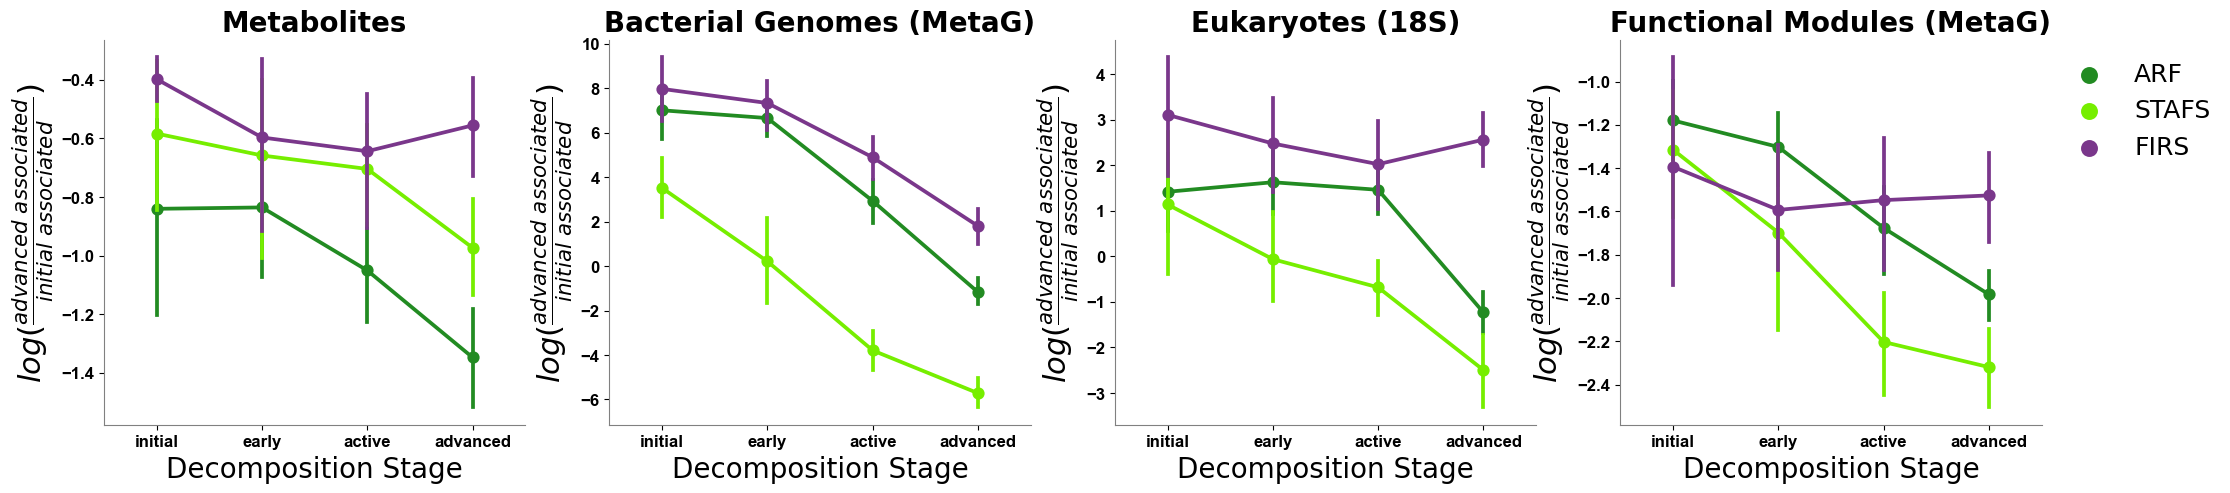

In [14]:
#joint-rpca trajectories
log_ratio_plot(metadata_logratios, save=True, 
               save_path='../results/joint-rpca/figures/joint-log-ratios.pdf')

### Individual RPCA trajectories

In [10]:
# get individual rpca version
orig_ordination_path = '../results/joint-rpca/Original/'
ords_rpca = {'metabolite': OrdinationResults.read('{}metabolite_ord.txt'.format(orig_ordination_path)), 
             'mag': OrdinationResults.read('{}mag_ord.txt'.format(orig_ordination_path)), 
             '18S': OrdinationResults.read('{}18S_ord.txt'.format(orig_ordination_path)), 
             'gene_module': OrdinationResults.read('{}gene_module_ord.txt'.format(orig_ordination_path)), 
             'metabolomics': OrdinationResults.read('{}metabolomics_ord.txt'.format(orig_ordination_path))}
axis_use_rpca = {'metabolite': 1, 'mag': 2, '18S': 2,
                 'gene_module': 1, 'metabolomics': 1}

#create new dict with rpca ordinations
tables_rpca = tables.copy()
for omic in tables_rpca.keys():
    omic_features = ords_rpca[omic].features.copy()
    id_set = set(omic_features.index) & set(tables[omic][0].ids('observation'))
    omic_features_tmp = omic_features.loc[list(id_set), :]
    
    axis_use_ = axis_use_rpca[omic]
    tables_rpca[omic][2] = omic_features_tmp.sort_values(by=axis_use_, ascending=False)

In [11]:
#first, save the top and bottom i_ features
features_used_rpca = {}
i_ = 19
for modality, (_, table_, ranks_) in tables_rpca.items():
    num = list(ranks_.iloc[:i_, :].index)
    den = list(ranks_.iloc[-i_:, :].index)
    features_used_rpca[modality] = [num[:i_], den[:i_]]

#save
with open("../results/joint-rpca/network/rpca_decomposer_feats.json", "w") as outfile: 
   json.dump(features_used_rpca, outfile)

In [12]:
#make each log-ratio based on axis
metadata_logratios_rpca = metadata_subset.copy()
for modality, (_, table_, ranks_) in tables_rpca.items():
    for i_ in range(1, 1500):
        num = list(ranks_.iloc[:i_, :].index)
        den = list(ranks_.iloc[-i_:, :].index)
        lr_ = np.log(table_.loc[num, :].sum(0)) - np.log(table_.loc[den, :].sum(0))
        if (sum(np.isfinite(lr_)) / table_.shape[1]) >= 0.99:
            break
    print(modality, i_)
    print(sum(np.isfinite(lr_)) / table_.shape[1])
    lr_[~np.isfinite(lr_)] = np.nan
    metadata_logratios_rpca[modality + '_logratio'] = lr_

metabolite 71
0.9973262032085561
mag 14
0.9919786096256684
18S 1499
0.8636363636363636
gene_module 4
0.9946524064171123
metabolomics 30
0.9919786096256684


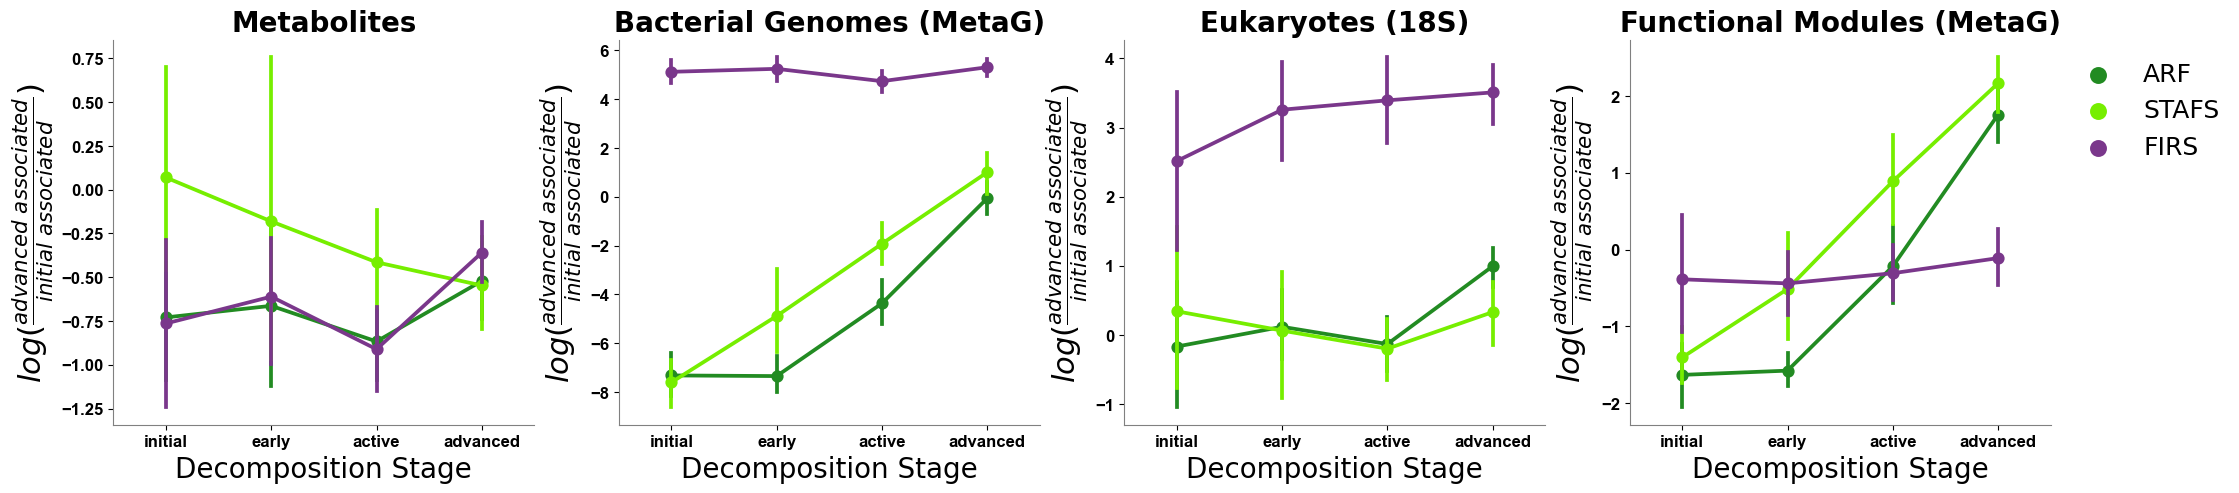

In [15]:
#rpca trajectories
log_ratio_plot(metadata_logratios_rpca, save=True, 
               save_path='../results/joint-rpca/figures/rpca-log-ratios.pdf')